<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>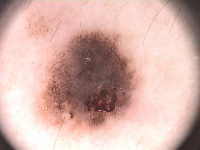</td><td>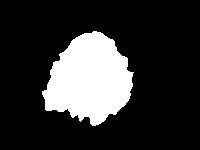</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
# Скачивание датасета
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql 

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=13102fbb-559b-4d9f-a473-80e454e8b917
To: /kaggle/working/PH2Dataset.rar
100%|█████████████████████████████████████████| 162M/162M [00:01<00:00, 160MB/s]


In [2]:
# Распаковка датасета
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
# загрузка изображений и масок
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

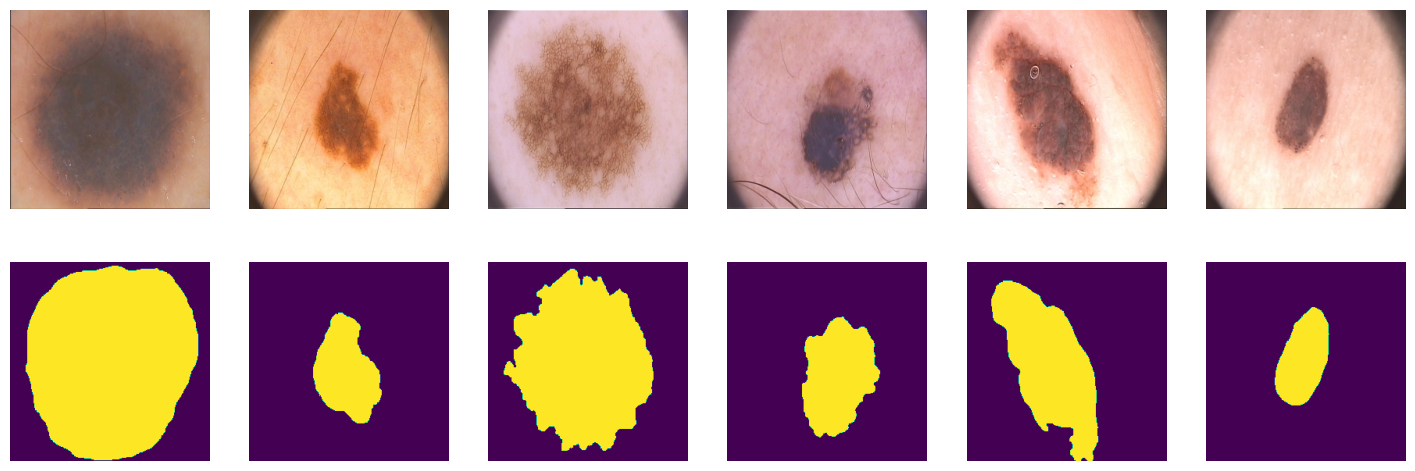

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 15
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return -torch.sum(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 5.511260986328125
BCE loss честно посчитанный = 5.511260032653809
BCE loss from torch bce_torch = 5.511260032653809
BCE loss from torch with logits bce_torch = 5.511260986328125


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 13.111153602600098
BCE loss честно посчитанный = 13.111152648925781
BCE loss from torch bce_torch = 13.111152648925781
BCE loss from torch with logits bce_torch = 13.111153602600098


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
import gdown 
id = "1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M"
gdown.download_folder(id=id)

Retrieving folder contents


Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████| 1.18k/1.18k [00:00<00:00, 2.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████| 1.18k/1.18k [00:00<00:00, 5.71MB/s]
Download completed


['/kaggle/working/for_asserts/labels.pt',
 '/kaggle/working/for_asserts/logits.pt']

In [21]:
path_to_dummy_samples = '/kaggle/working/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

<ipython-input-21-4356085ddc34>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
<ipython-input-

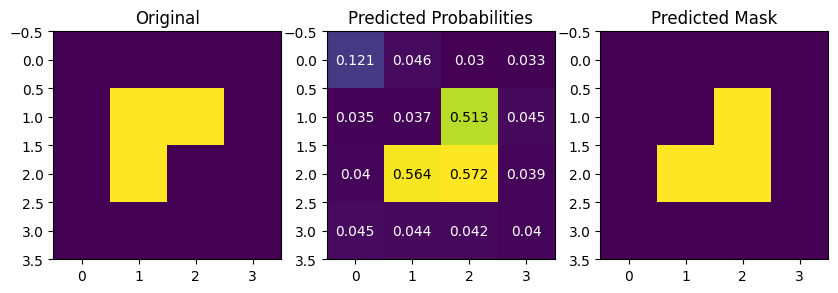

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

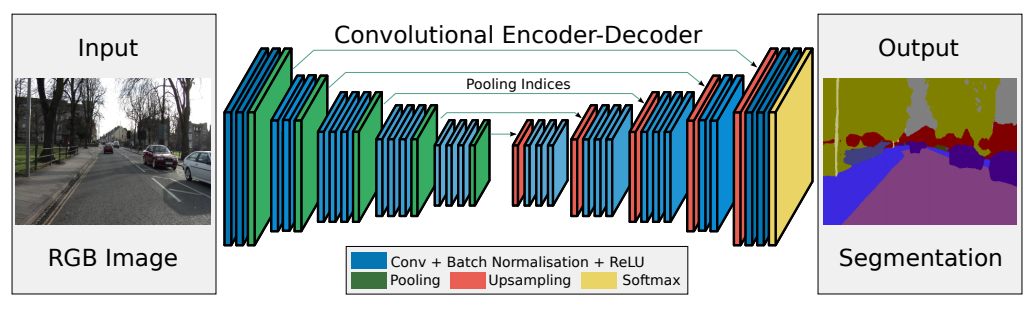

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time


from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [25]:
import torch
import torch.nn as nn

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        ''' encoder (VGG-16 architecture) '''
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # First block
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Second block
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Third block
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Fourth block
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Fifth block
        self.enc5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        ''' bottleneck '''
        self.bottleneck = nn.Conv2d(512, 512, kernel_size=1)

        ''' decoder (upsampling) '''
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # Fifth block
        self.dec5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Fourth block
        self.dec4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Third block
        self.dec3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Second block
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # First block
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        x = self.enc1(x)
        x, ind1 = self.pool(x)
        size1 = x.shape

        x = self.enc2(x)
        x, ind2 = self.pool(x)
        size2 = x.shape

        x = self.enc3(x)
        x, ind3 = self.pool(x)
        size3 = x.shape

        x = self.enc4(x)
        x, ind4 = self.pool(x)
        size4 = x.shape

        x = self.enc5(x)
        x, ind5 = self.pool(x)

        # bottleneck
        x = self.bottleneck(x)

        # decoder
        x = self.unpool(x, ind5, output_size=size4)
        x = self.dec5(x)

        x = self.unpool(x, ind4, output_size=size3)
        x = self.dec4(x)

        x = self.unpool(x, ind3, output_size=size2)
        x = self.dec3(x)

        x = self.unpool(x, ind2, output_size=size1)
        x = self.dec2(x)

        x = self.unpool(x, ind1)
        output = self.dec1(x)

        return output  # no activation

In [26]:
segnet_model = SegNet().to(device)


## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [27]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [28]:
def fit_epoch(model, criterion, optimizer, train_loader, device):
    """
    Обучает модель на одной эпохе.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    epoch_iou = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        epoch_iou += iou_score(outputs, labels).item()

    epoch_loss = running_loss / total_samples
    epoch_iou /= len(train_loader)
    return epoch_loss, epoch_iou

def val_epoch(model, criterion, val_loader, device):
    """
    Валидирует модель на одной эпохе.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    epoch_iou = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            epoch_iou += iou_score(outputs, labels).item()

    epoch_loss = running_loss / total_samples
    epoch_iou /= len(val_loader)
    return epoch_loss, epoch_iou

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    """
    Обучает модель на протяжении нескольких эпох.
    """
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        print(f'Эпоха {epoch + 1}/{epochs}')

        train_loss, train_iou = fit_epoch(model, criterion, optimizer, train_loader, device)
        train_losses.append(train_loss)
        train_ious.append(train_iou)

        val_loss, val_iou = val_epoch(model, criterion, val_loader, device)
        val_losses.append(val_loss)
        val_ious.append(val_iou)

        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}")

    plot_losses(train_losses, val_losses, train_ious, val_ious)

def plot_losses(train_losses, val_losses, train_iou, val_iou):
    """
    Визуализирует потери и IoU на графиках.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_iou, label="Train IoU")
    plt.plot(val_iou, label="Val IoU")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title("Train and Validation IoU")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def iou_score(outputs, labels):
    """
    Вычисляет метрику IoU (Intersection over Union).
    """
    #preds = torch.argmax(outputs, dim=1) 
    
    # Вычисляем IoU
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    iou = iou_score(outputs, labels)
    return iou

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 1/20
Train Loss: 0.6077, Val Loss: 0.6514, Train IoU: 0.1763, Val IoU: 0.0380
Эпоха 2/20
Train Loss: 0.4120, Val Loss: 0.5716, Train IoU: 0.4804, Val IoU: 0.0963
Эпоха 3/20
Train Loss: 0.2903, Val Loss: 0.7909, Train IoU: 0.6616, Val IoU: 0.0325
Эпоха 4/20
Train Loss: 0.2800, Val Loss: 0.4276, Train IoU: 0.6904, Val IoU: 0.3533
Эпоха 5/20
Train Loss: 0.2684, Val Loss: 0.6202, Train IoU: 0.7055, Val IoU: 0.1962
Эпоха 6/20
Train Loss: 0.2373, Val Loss: 0.2753, Train IoU: 0.7324, Val IoU: 0.6628
Эпоха 7/20
Train Loss: 0.2165, Val Loss: 0.2828, Train IoU: 0.7520, Val IoU: 0.6879
Эпоха 8/20
Train Loss: 0.2124, Val Loss: 0.2943, Train IoU: 0.7582, Val IoU: 0.7207
Эпоха 9/20
Train Loss: 0.2352, Val Loss: 0.4228, Train IoU: 0.7145, Val IoU: 0.3836
Эпоха 10/20
Train Loss: 0.2391, Val Loss: 0.3074, Train IoU: 0.7366, Val IoU: 0.6757
Эпоха 11/20
Train Loss: 0.2849, Val Loss: 0.4843, Train IoU: 0.6775, Val IoU: 0.6213
Эпоха 12/20
Train Loss: 0.2197, Val Loss: 0.2891, Train IoU: 0.7164, Val I

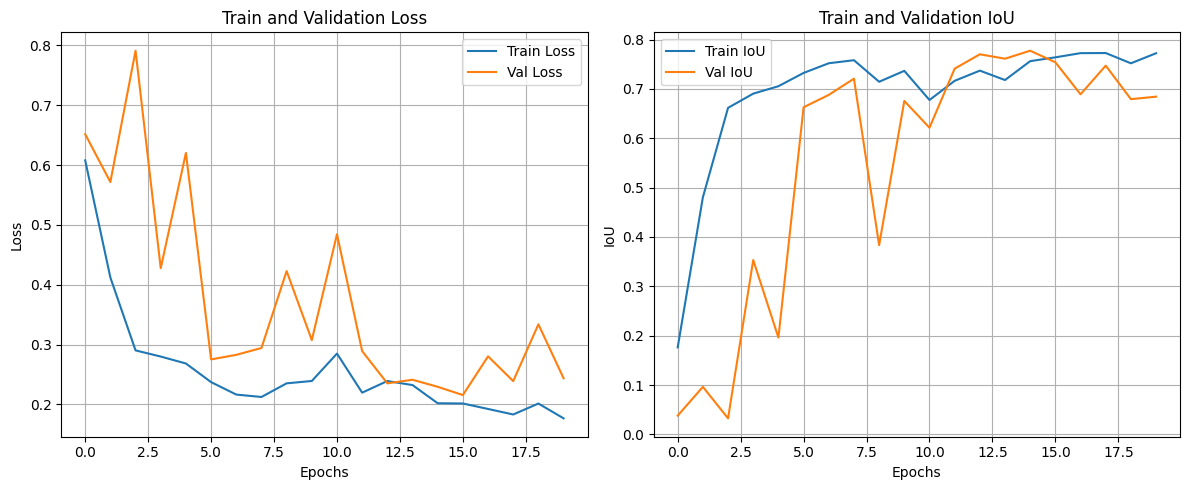

In [29]:
model = SegNet()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model = model.to(device)

train_model(model, criterion, optimizer, train_dataloader, valid_dataloader, epochs=20, device=device)


Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [30]:
def test(model, dataloader):
    iou_res = 0

    model.eval()
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            iou = iou_score(outputs, labels)
            iou_res += iou
    return iou_res / len(dataloader)


In [31]:
test(model, test_dataloader)


tensor(0.7713, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [32]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    log_sigm = torch.sigmoid(logits)
    preds = (log_sigm >= threshold).float()
    
    TP = torch.sum(preds*labels)
    FP = torch.sum(preds) - TP
    FN = torch.sum(labels) - TP

    eps = 1e-8

    score = (2 * TP + eps) / (2 * TP + FP + FN + eps)
    
    return score

Проверим на корректность функцию dice_score:

In [33]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [34]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [35]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    preds = torch.sigmoid(logits)
    
    TP = torch.sum(preds*labels)
    FP = torch.sum(preds) - TP
    FN = torch.sum(labels) - TP

    eps = 1e-8

    score = (2 * TP + eps) / (2 * TP + FP + FN + eps)

    return 1 - score

Проверка на корректность:

In [36]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6c0402afbbe32359ef2acf1ac3872c1dea43dab0a56e68722a66009118c3c6f4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e665c515ab581d096ea100b125ca89c0e4c9ae9b1b7e3c4e0bdfeaded0a4c918
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [37]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [38]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [39]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    p = torch.sigmoid(y_pred) * y_real + (1 - torch.sigmoid(y_pred)) * (1 - y_real)
    bce_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    focal_factor = (1 - p) ** gamma
    loss = torch.sum(focal_factor * bce_loss)

    return loss

Проверка корректности функции:

In [40]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [41]:
focal_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(3.6161, device='cuda:0')

In [42]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

В качестве статьи я выбрал:

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

В данной статье описывается функция потерь под названием Boundary Loss, которая отличается от таких функций, как Dice Loss или Cross-Entropy Loss, тем, что считает интегралы не по областям, а по границам областей (подсчитывает расстояние между пикселями разных объектов, тем самым, разделяет их более эффективно).

Таким образом, она хорошо работает с дисбалансом классов (так как позволяет эффективно сегментировать малые объекты на больших фонах), а также является дополнением к классическим функциям потерь.

Эта функция используется в задачах сегментации медицинских изображений, где важно сегментировать очень маленькие опухоли или поражения. (Возможно, она не совсем подходит именно для этой задачи, но среди остальных статей, на мой взгляд, является одной из наиболее полезных в дальнейшем.)

Как я уже говорил, она используется как дополнение к другим функциям потерь, поэтому мы будем применять её совместно с Dice Loss, который уже был реализован в этом ноутбуке.

In [43]:
def boundary_loss(y_true, y_pred, smooth=1.0):
    sobel_x = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = sobel_x.transpose(0, 1)

    if y_pred.is_cuda:
        sobel_x = sobel_x.cuda()
        sobel_y = sobel_y.cuda()

    y_true = y_true[:, 0, :, :]  # Remove channel dimension
    y_pred = y_pred[:, 0, :, :]  # Remove channel dimension

    y_true = F.pad(y_true, (1, 1, 1, 1), mode='reflect')
    y_pred = F.pad(y_pred, (1, 1, 1, 1), mode='reflect')

    # Calculate gradients
    dx_true = F.conv2d(y_true.unsqueeze(1), sobel_x.unsqueeze(0).unsqueeze(0), padding=0).squeeze(1)
    dy_true = F.conv2d(y_true.unsqueeze(1), sobel_y.unsqueeze(0).unsqueeze(0), padding=0).squeeze(1)
    dx_pred = F.conv2d(y_pred.unsqueeze(1), sobel_x.unsqueeze(0).unsqueeze(0), padding=0).squeeze(1)
    dy_pred = F.conv2d(y_pred.unsqueeze(1), sobel_y.unsqueeze(0).unsqueeze(0), padding=0).squeeze(1)

    # Calculate boundaries
    boundary_true = torch.abs(dx_true) + torch.abs(dy_true)
    boundary_pred = torch.abs(dx_pred) + torch.abs(dy_pred)

    # Calculate boundary loss
    intersection = torch.sum(boundary_true * boundary_pred)
    denominator = torch.sum(boundary_true.pow(2)) + torch.sum(boundary_pred.pow(2)) + smooth
    boundary_loss = 1 - 2 * intersection / denominator

    return boundary_loss

In [44]:
boundary_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.4938, device='cuda:0')

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.

см. ответ ниже



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 1/20
Train Loss: 0.9168, Val Loss: 0.9774, Train IoU: 0.2407, Val IoU: 0.1797
Эпоха 2/20
Train Loss: 0.8599, Val Loss: 0.9285, Train IoU: 0.2330, Val IoU: 0.2830
Эпоха 3/20
Train Loss: 0.8013, Val Loss: 0.8369, Train IoU: 0.2363, Val IoU: 0.2574
Эпоха 4/20
Train Loss: 0.7703, Val Loss: 0.7873, Train IoU: 0.2391, Val IoU: 0.2288
Эпоха 5/20
Train Loss: 0.7429, Val Loss: 0.7716, Train IoU: 0.2423, Val IoU: 0.2142
Эпоха 6/20
Train Loss: 0.7230, Val Loss: 0.7869, Train IoU: 0.2318, Val IoU: 0.2500
Эпоха 7/20
Train Loss: 0.6997, Val Loss: 0.7127, Train IoU: 0.2190, Val IoU: 0.1969
Эпоха 8/20
Train Loss: 0.6892, Val Loss: 0.7322, Train IoU: 0.2198, Val IoU: 0.2387
Эпоха 9/20
Train Loss: 0.7016, Val Loss: 0.7189, Train IoU: 0.2138, Val IoU: 0.2298
Эпоха 10/20
Train Loss: 0.6868, Val Loss: 0.7080, Train IoU: 0.2244, Val IoU: 0.2136
Эпоха 11/20
Train Loss: 0.6727, Val Loss: 0.6742, Train IoU: 0.2211, Val IoU: 0.2243
Эпоха 12/20
Train Loss: 0.6646, Val Loss: 0.6657, Train IoU: 0.2130, Val I

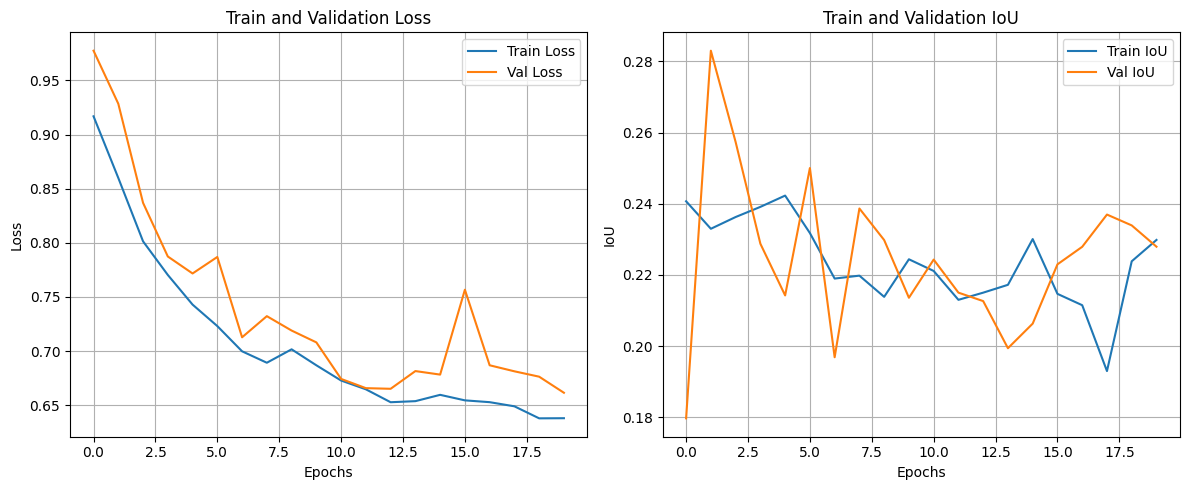

In [45]:
model = SegNet()
criterion = lambda logits, labels: boundary_loss(logits, labels)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 
model = model.to(device)

train_model(model, criterion, optimizer, train_dataloader, valid_dataloader, epochs=20, device=device)


*   При каком лоссе модель сходится быстрее?
  Быстрее модель сходится по BCE лоссу, но, к сожалению, из-за частого перезапуска ноутбука - графики меняются. Иногда быстрее сходился и имплементированный лосс
*   При каком лоссе модель выдает наилучшую метрику?
  При BCE лоссе метрики лучше, однако, предполагаю, что при дальнейшем обучении на 100 эпох, модель с имплементированным лоссом сможет дойти до тех же показателей

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

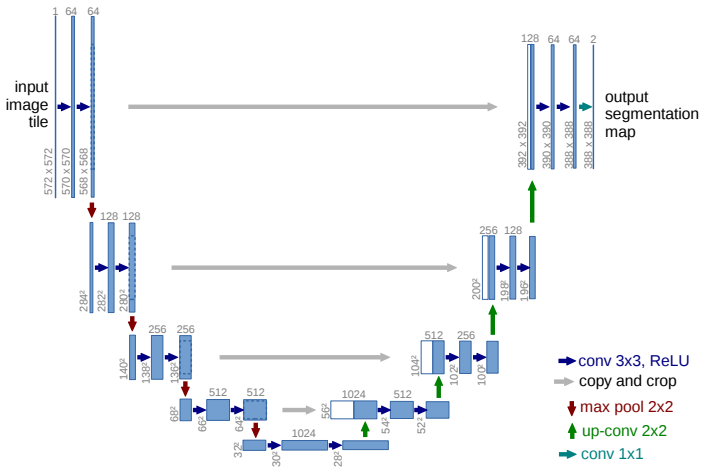

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [46]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        ''' Encoder '''
        # Первый блок
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Второй блок
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Третий блок
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Четвертый блок
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        ''' Decoder '''
        # Четвертый блок
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Третий блок
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Второй блок
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Первый блок
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Выходной слой
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Output
        out = self.out_conv(d1)
        return out

In [47]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 1/20
Train Loss: 0.4759, Val Loss: 17972.7594, Train IoU: 0.4798, Val IoU: 0.3354
Эпоха 2/20
Train Loss: 0.3453, Val Loss: 140.3503, Train IoU: 0.6234, Val IoU: 0.3471
Эпоха 3/20
Train Loss: 0.2744, Val Loss: 2.3285, Train IoU: 0.7242, Val IoU: 0.4917
Эпоха 4/20
Train Loss: 0.2654, Val Loss: 0.7307, Train IoU: 0.7009, Val IoU: 0.6294
Эпоха 5/20
Train Loss: 0.2288, Val Loss: 0.4064, Train IoU: 0.7718, Val IoU: 0.6633
Эпоха 6/20
Train Loss: 0.2412, Val Loss: 0.3478, Train IoU: 0.7430, Val IoU: 0.6604
Эпоха 7/20
Train Loss: 0.2142, Val Loss: 0.3029, Train IoU: 0.7684, Val IoU: 0.6777
Эпоха 8/20
Train Loss: 0.2056, Val Loss: 0.4730, Train IoU: 0.7762, Val IoU: 0.6033
Эпоха 9/20
Train Loss: 0.2174, Val Loss: 0.3389, Train IoU: 0.7643, Val IoU: 0.6928
Эпоха 10/20
Train Loss: 0.2498, Val Loss: 0.4268, Train IoU: 0.7263, Val IoU: 0.6051
Эпоха 11/20
Train Loss: 0.2172, Val Loss: 0.2413, Train IoU: 0.7623, Val IoU: 0.7656
Эпоха 12/20
Train Loss: 0.1967, Val Loss: 0.2225, Train IoU: 0.7742,

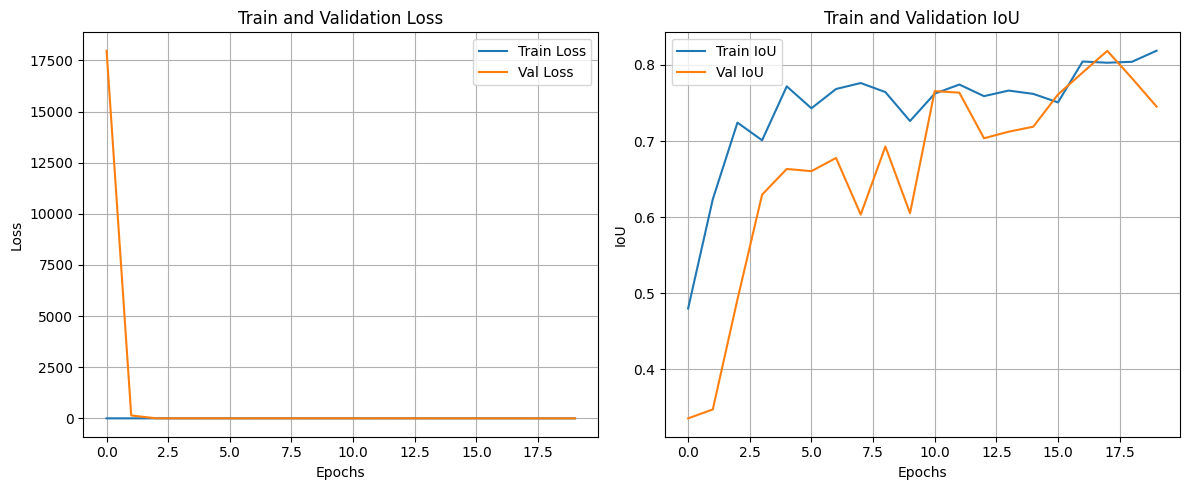

In [50]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
unet_model_bce = unet_model

train_model(unet_model_bce,
            criterion, optimizer,
            train_dataloader,
            valid_dataloader,
            epochs=20,
            device=device)


In [53]:
test(unet_model_bce, test_dataloader)

tensor(0.7612, device='cuda:0')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 1/20
Train Loss: 0.1445, Val Loss: 0.1460, Train IoU: 0.8461, Val IoU: 0.8119
Эпоха 2/20
Train Loss: 0.1347, Val Loss: 0.1471, Train IoU: 0.8228, Val IoU: 0.7936
Эпоха 3/20
Train Loss: 0.1442, Val Loss: 0.1396, Train IoU: 0.7990, Val IoU: 0.8279
Эпоха 4/20
Train Loss: 0.1252, Val Loss: 0.1534, Train IoU: 0.8270, Val IoU: 0.8068
Эпоха 5/20
Train Loss: 0.1175, Val Loss: 0.1346, Train IoU: 0.8309, Val IoU: 0.8205
Эпоха 6/20
Train Loss: 0.1268, Val Loss: 0.2166, Train IoU: 0.8093, Val IoU: 0.6663
Эпоха 7/20
Train Loss: 0.1822, Val Loss: 0.2131, Train IoU: 0.7203, Val IoU: 0.7112
Эпоха 8/20
Train Loss: 0.1582, Val Loss: 0.1459, Train IoU: 0.7538, Val IoU: 0.7811
Эпоха 9/20
Train Loss: 0.1253, Val Loss: 0.1574, Train IoU: 0.7978, Val IoU: 0.7793
Эпоха 10/20
Train Loss: 0.1435, Val Loss: 0.1406, Train IoU: 0.7796, Val IoU: 0.7658
Эпоха 11/20
Train Loss: 0.1316, Val Loss: 0.1407, Train IoU: 0.7893, Val IoU: 0.7385
Эпоха 12/20
Train Loss: 0.1129, Val Loss: 0.1360, Train IoU: 0.8185, Val I

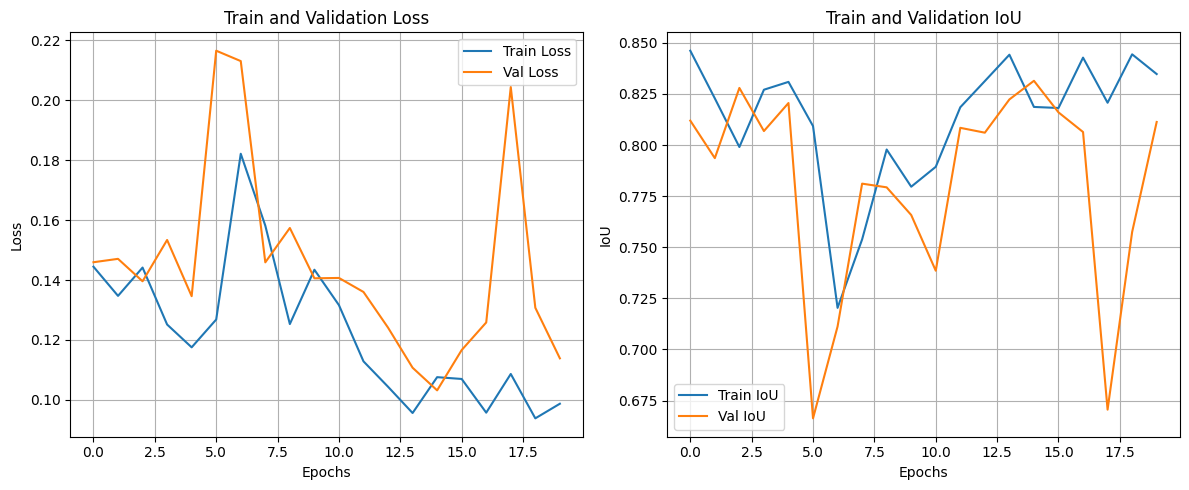

In [54]:
criterion = DiceLoss(mode='binary')
unet_model_dice = unet_model
train_model(unet_model_dice,
            criterion,
            optimizer,
            train_dataloader, 
            valid_dataloader, 
            epochs=20,
            device=device)


In [58]:
test(unet_model_dice, test_dataloader)

tensor(0.8332, device='cuda:0')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Эпоха 1/20
Train Loss: 274796.8812, Val Loss: 106668066.6000, Train IoU: 0.6419, Val IoU: 0.3353
Эпоха 2/20
Train Loss: 81488.0164, Val Loss: 39975757.0000, Train IoU: 0.6814, Val IoU: 0.0016
Эпоха 3/20
Train Loss: 72800.1105, Val Loss: 11935347.7000, Train IoU: 0.6623, Val IoU: 0.0173
Эпоха 4/20
Train Loss: 70727.6746, Val Loss: 1105771.5906, Train IoU: 0.6837, Val IoU: 0.1510
Эпоха 5/20
Train Loss: 60596.3385, Val Loss: 62885.1781, Train IoU: 0.7124, Val IoU: 0.7629
Эпоха 6/20
Train Loss: 51018.4121, Val Loss: 57231.1859, Train IoU: 0.7419, Val IoU: 0.7529
Эпоха 7/20
Train Loss: 47209.4307, Val Loss: 71016.2207, Train IoU: 0.7891, Val IoU: 0.7216
Эпоха 8/20
Train Loss: 58540.6394, Val Loss: 49401.4480, Train IoU: 0.7361, Val IoU: 0.8015
Эпоха 9/20
Train Loss: 52692.1096, Val Loss: 49602.9742, Train IoU: 0.7533, Val IoU: 0.7757
Эпоха 10/20
Train Loss: 47921.1629, Val Loss: 82863.9573, Train IoU: 0.7858, Val IoU: 0.6880
Эпоха 11/20
Train Loss: 46572.6799, Val Loss: 41505.7361, Train Io

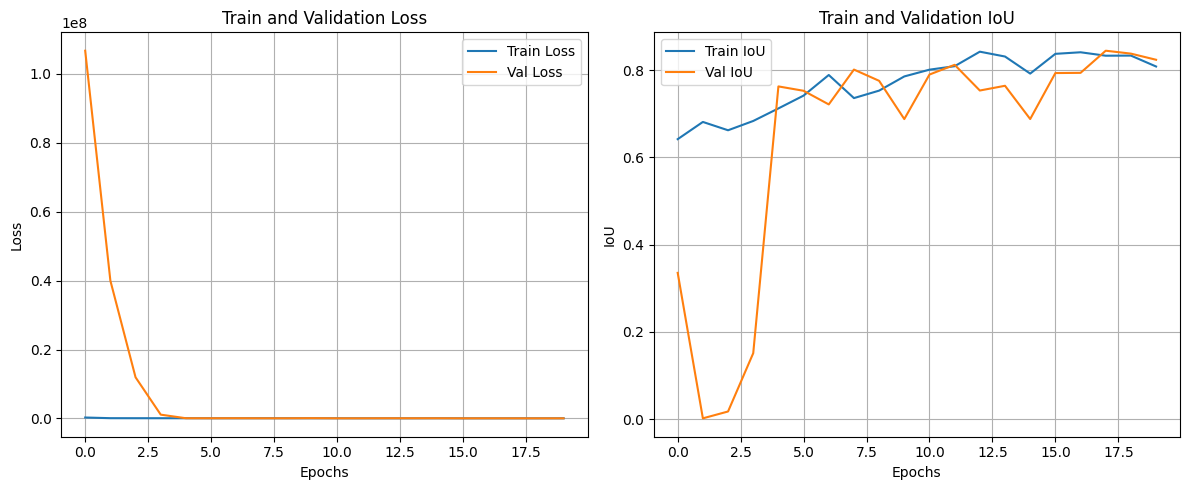

In [60]:
criterion = lambda labels, logits: focal_loss(labels, logits)
unet_model_focal = unet_model
train_model(unet_model_focal,
            criterion,
            optimizer,
            train_dataloader,
            valid_dataloader,
            epochs=20,
            device=device)


In [61]:
test(unet_model_focal, test_dataloader)

tensor(0.8257, device='cuda:0')

* Лучше всего себя показал U-Net на Dice лоссе, обойдя другие лоссы и SegNet с BCE лоссом
Несмотря на то, что U-Net был протестирован на нескольких лоссах, в среднем он везде показал результаты лучше, чем SegNet (речь идет про IoU) 
    
* Обе модели обучаются быстро, но SegNet быстрее, нежели UNet (с одинаковым кол-вом эпох и батчей


Вывод - SegNet быстрее, обе модели выглядят стабильными, но бывают пошатывания. На метриках и лоссах лучшей моделью стал U-Net 